<a href="https://colab.research.google.com/github/jennyt14/mathbiou/blob/main/Exploring_American_Opinion_on_Gays_and_Lesbians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Methods of Computational Biology to Study American Opinion: Gays and Lesbians

# Exploring the ANES Data

In [ ]:
#upload the data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
from scipy.optimize import curve_fit
from scipy.integrate import odeint

In [ ]:
#read file
df=pd.read_csv('gdrive/My Drive/anes_timeseries_cdf_csv_20211118.csv')
df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4,5,6,7,8,9,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,37,38,39,40,41,42,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,232,253,274,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,360,

,Version,VCF0004,VCF0006,VCF0006a,VCF0009x,VCF0010x,VCF0011x,VCF0009y,VCF0010y,VCF0011y,...,VCF9272,VCF9273,VCF9274,VCF9275,VCF9277,VCF9278,VCF9279,VCF9280,VCF9281,VCF9282
0,ANES_CDF_VERSION:2021-Nov-18,1948,1001,19481001,1,1,1,1,1,1,...,,,,,,,,,,
1,ANES_CDF_VERSION:2021-Nov-18,1948,1002,19481002,1,1,1,1,1,1,...,,,,,,,,,,
2,ANES_CDF_VERSION:2021-Nov-18,1948,1003,19481003,1,1,1,1,1,1,...,,,,,,,,,,
3,ANES_CDF_VERSION:2021-Nov-18,1948,1004,19481004,1,1,1,1,1,1,...,,,,,,,,,,
4,ANES_CDF_VERSION:2021-Nov-18,1948,1005,19481005,1,1,1,1,1,1,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68219,ANES_CDF_VERSION:2021-Nov-18,2020,535315,2020535315,,,,,,,...,3,4,,,,,1,1,1,
68220,ANES_CDF_VERSION:2021-Nov-18,2020,535360,2020535360,,,,,,,...,-9,-9,,,,,1,2,2,
68221,ANES_CDF_VERSION:2021-Nov-18,2020,535414,2020535414,,,,,,,...,-9,-9,,,,,1,1,1,
68222,ANES_CDF_VERSION:2021-Nov-18,2020,535421,2020535421,,,,,,,...,2,2,,,,,1,1,1,


In [ ]:
#create new dataframe with year and opinion on Gays and Lesbians
gay_therm = df[['VCF0004', 'VCF0232']]
#replaces empty cells with np.nan
gay_therm = gay_therm.replace(r'^\s*$', np.nan, regex=True)
#removes rows with empty cell
gay_therm = gay_therm.dropna()
#change the type of the column to integers
gay_therm = gay_therm.astype('int')
#make a list with values we are going to delete
val = [98, 99]
#makes a list without 98, 99
gay_therm = gay_therm[gay_therm['VCF0232'].isin(val) == False]
gay_therm

,VCF0004,VCF0232
27180,1984,50
27181,1984,40
27182,1984,0
27183,1984,15
27184,1984,0
...,...,...
68219,2020,50
68220,2020,60
68221,2020,50
68222,2020,50


In [ ]:
#creating a new dataframe
gay_years = list(gay_therm['VCF0004'].unique())
val = [['year', 'anti average', 'mid average', 'pro average']]
for n in gay_years:
  a = gay_therm[gay_therm['VCF0004'] == n]
  total = gay_therm['VCF0004'].value_counts()[n]
  antig = len(a[a['VCF0232'] <= 25]) / total
  midg = len(a[(a['VCF0232'] > 25) & (a['VCF0232'] < 75)]) / total
  prog = len(a[a['VCF0232'] >= 75]) / total
  val.append([n - 1984, antig, midg, prog])

df_gay = pd.DataFrame(val[1:],columns=val[0])
df_gay

,year,anti average,mid average,pro average
0,0,0.460187,0.491488,0.048325
1,4,0.472554,0.479714,0.047733
2,8,0.330110,0.593462,0.076427
3,10,0.395845,0.519331,0.084824
4,12,0.290909,0.629630,0.079461
5,14,0.240297,0.618497,0.141206
6,16,0.222376,0.611188,0.166436
7,18,0.221260,0.621260,0.157480
8,20,0.182950,0.659962,0.157088
9,24,0.188633,0.640862,0.170505


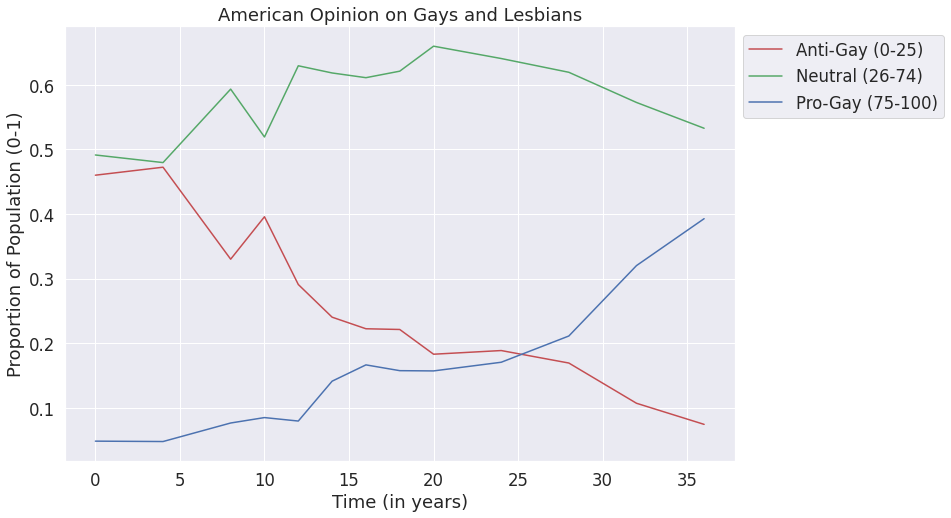

In [ ]:
#makes bigger figures
fig_dims = (12, 8)
fig, ax = pyplot.subplots(figsize=fig_dims)

#plots graph
sns.set(font_scale = 1.5)
sns.lineplot(x = 'year', y = 'anti average',
             data = df_gay, color = 'r').set(Title =
             'American Opinion on Gays and Lesbians', xlabel =
             'Time (in years)', ylabel = 'Proportion of Population (0-1)')
sns.lineplot(x = 'year', y = 'mid average', data = df_gay, color = 'g')
sns.lineplot(x = 'year', y = 'pro average', data = df_gay, color = 'b')
sns.set(font_scale = 1.5)
pyplot.legend(bbox_to_anchor=
              (1,1) ,labels=["Anti-Gay (0-25)",
              "Neutral (26-74)",
              "Pro-Gay (75-100)"])

# Mathematical Model

In [ ]:
# define our system of differential equations
def pna(y, t):
  p, n, a = y
  dPdt = beta*n*p
  dNdt = -beta*n*p+zeta*a*n
  dAdt = -zeta*a*n
  dydt = [dPdt,dNdt,dAdt]
  return dydt

# initial conditions
beta = 0 #unknown
zeta = 0 #unknown
p0 = .05
n0 = .49
a0 = .46
y0 = [p0, n0, a0]

# time points
t = np.arange(0,37,1)

# solve ODE
y = odeint(pna,y0,t)

# Least Square Error Method

In [ ]:
fit_beta = np.arange(0,0.11,0.01)
fit_zeta = np.arange(0,0.11,0.01)
lst_t = list(t)
unique_years = list(df_gay['year'])
beta_lst = []
zeta_lst = []
error_lst = []

In [ ]:
for n in fit_beta:
  for i in fit_zeta:
    beta = n
    zeta = i
    y = odeint(pna,y0,t)

    lst_red = list(y[:,2])

    dic = dict(zip(lst_t, lst_red))
    new_dic = {}
    for key, val in dic.items():
      if key in unique_years:
        new_dic[key] = val
    anti = np.array(list(df_gay['anti average']))
    pred_anti = np.array(list(new_dic.values()))
    S_red = list(np.subtract(pred_anti, anti))
    S_red = [num ** 2 for num in S_red]
    S_red = sum(S_red)

    lst_green = list(y[:,1])

    dic = dict(zip(lst_t, lst_green))
    new_dic = {}
    for key, val in dic.items():
      if key in unique_years:
        new_dic[key] = val
    mid = np.array(list(df_gay['mid average']))
    pred_mid = list(new_dic.values())
    S_green = list(np.subtract(pred_mid, mid))
    S_green = [num ** 2 for num in S_green]
    S_green = sum(S_green)

    lst_blue = list(y[:,0])

    dic = dict(zip(lst_t, lst_blue))
    new_dic = {}
    for key, val in dic.items():
      if key in unique_years:
        new_dic[key] = val

    pro = np.array(list(df_gay['pro average']))
    pred_pro = list(new_dic.values())
    S_blue = list(np.subtract(pred_pro, pro))
    S_blue = [num ** 2 for num in S_blue]
    S_blue = sum(S_blue)

    error = S_red + S_blue + S_green
    beta_lst.append(n)
    zeta_lst.append(i)
    error_lst.append(error)
    print(f'beta = {n}, zeta = {i}')
    print(f'{error}\n')

beta = 0.0, zeta = 0.0
1.1551702328171618

beta = 0.0, zeta = 0.01
0.8318891911037907

beta = 0.0, zeta = 0.02
0.6172952923020714

beta = 0.0, zeta = 0.03
0.5003670207094238

beta = 0.0, zeta = 0.04
0.4623022534662916

beta = 0.0, zeta = 0.05
0.48222426662107454

beta = 0.0, zeta = 0.06
0.5412732816252794

beta = 0.0, zeta = 0.07
0.6244826940727455

beta = 0.0, zeta = 0.08
0.7209858283511854

beta = 0.0, zeta = 0.09
0.823380347343885

beta = 0.0, zeta = 0.1
0.9268630857382767

beta = 0.01, zeta = 0.0
1.1489996548146615

beta = 0.01, zeta = 0.01
0.8203863504281304

beta = 0.01, zeta = 0.02
0.5985297986014836

beta = 0.01, zeta = 0.03
0.4731892300622107

beta = 0.01, zeta = 0.04
0.42636786568820817

beta = 0.01, zeta = 0.05
0.43781931459141515

beta = 0.01, zeta = 0.06
0.48907045926948095

beta = 0.01, zeta = 0.07
0.5653269693288356

beta = 0.01, zeta = 0.08
0.6557480704699864

beta = 0.01, zeta = 0.09
0.7528758921575659

beta = 0.01, zeta = 0.1
0.8518163910227289

beta = 0.02, zeta = 0.

Text(0.5, 1.0, 'Heat Map of Parameters and Corresponding Errors')

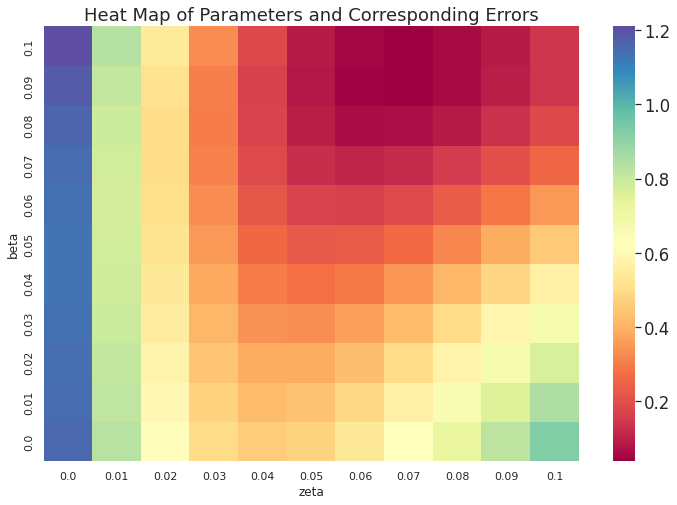

In [ ]:
param = {}
param['beta'] = beta_lst
param['zeta'] = zeta_lst
param['error'] = error_lst
df_param = pd.DataFrame(param)
param = df_param.pivot('beta', 'zeta', 'error')


#make plot bigger
fig_dims = (12, 8)
fig, ax = pyplot.subplots(figsize=fig_dims)
sns.set(font_scale = 1.5)

colormap = sns.color_palette("Spectral", as_cmap=True)
sns.heatmap(param, cmap = colormap).invert_yaxis()
pyplot.title('Heat Map of Parameters and Corresponding Errors')

beta = 0.09 and zeta = 0.07 produces the smallest error

# Results

In [ ]:
beta = 0.09
zeta = 0.07
t = np.arange(0,37,1)
y = odeint(pna, y0, t)

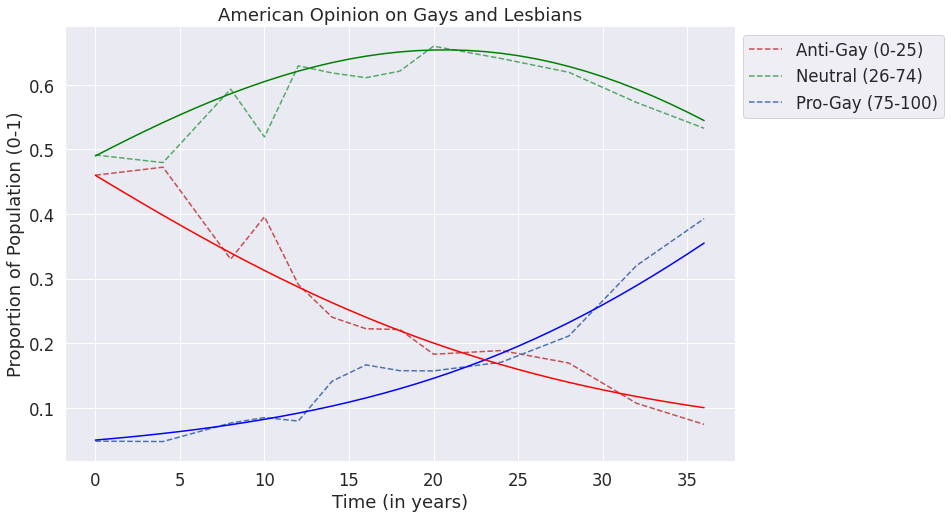

In [ ]:
#make plot bigger
fig_dims = (12, 8)
fig, ax = pyplot.subplots(figsize=fig_dims)

sns.lineplot(x = 'year', y = 'anti average',
             data = df_gay, color = 'r', linestyle = '--').set(Title =
             'American Opinion on Gays and Lesbians', xlabel =
             'Time (in years)', ylabel = 'Proportion of Population (0-1)')
sns.lineplot(x = 'year', y = 'mid average', data = df_gay, color = 'g', linestyle = '--')
sns.lineplot(x = 'year', y = 'pro average', data = df_gay, color = 'b', linestyle = '--')
pyplot.legend(bbox_to_anchor=
              (1,1) ,labels=["Anti-Gay (0-25)",
              "Neutral (26-74)",
              "Pro-Gay (75-100)"])

pyplot.plot(t,y[:,0], color = 'blue')
pyplot.plot(t,y[:,1], color = 'green')
pyplot.plot(t,y[:,2], color = 'red')

Graphing Past Given Years

In [ ]:
#increase time span
t = np.arange(0,56,1)
y = odeint(pna, y0, t)

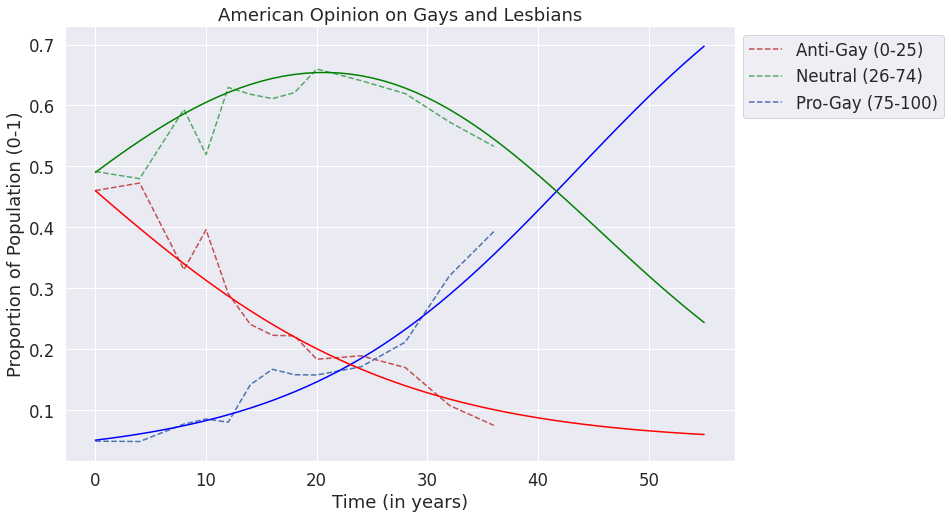

In [ ]:
#make plot bigger
fig_dims = (12, 8)
fig, ax = pyplot.subplots(figsize=fig_dims)

sns.lineplot(x = 'year', y = 'anti average',
             data = df_gay, color = 'r', linestyle = '--').set(Title =
             'American Opinion on Gays and Lesbians', xlabel =
             'Time (in years)', ylabel = 'Proportion of Population (0-1)')
sns.lineplot(x = 'year', y = 'mid average', data = df_gay, color = 'g', linestyle = '--')
sns.lineplot(x = 'year', y = 'pro average', data = df_gay, color = 'b', linestyle = '--')
pyplot.legend(bbox_to_anchor=
              (1,1) ,labels=["Anti-Gay (0-25)",
              "Neutral (26-74)",
              "Pro-Gay (75-100)"])

pyplot.plot(t,y[:,0], color = 'blue')
pyplot.plot(t,y[:,1], color = 'green')
pyplot.plot(t,y[:,2], color = 'red')